In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# L20 through learnable nonconvex surrogates of $l_0$ norm for sparse coding

In [2]:
def expSURROGATE(x, theta):
    return 1- np.exp(-theta*np.abs(x))

def pPosSURROGATE(x, eps, theta):
    return (np.abs(x) + eps)**(1/theta)

def pNegSURROGATE(x, theta, p):
    return 1 -(theta*np.abs(x) + 1)**p

def SCADSURROGATE(x, theta, a):
    if np.abs(x) <= 1/theta:
        return np.abs(x)*2*theta/(a+1)
    
    elif 1/theta <= np.abs(x) <= a/theta:
        return (-theta**2*np.abs(x)**2 + 2*a*theta*np.abs(x) - 1) / (a ** 2 - 1)
    
    else:
        return 1
    
def logSURROGATE(x, theta):
    return (np.log(1 + theta * np.abs(x))) / (np.log(1 + theta))

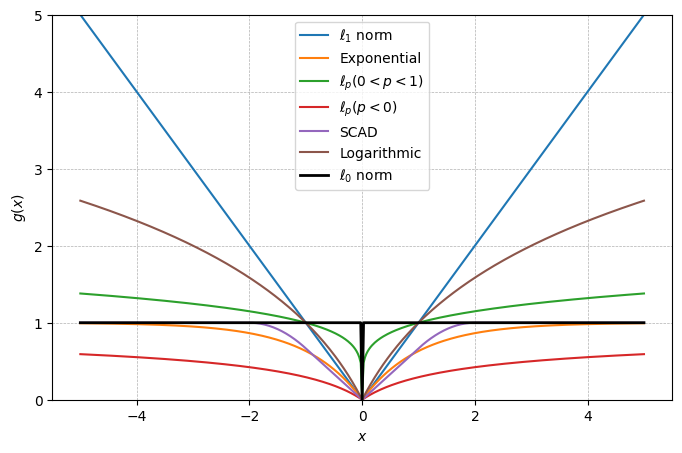

In [3]:
# Parameters
theta = 1
eps = 1e-10
a = 2
p = - 0.5
x_values = np.linspace(-5, 5, 401)

exp_values = expSURROGATE(x_values, theta)
pPos_values = pPosSURROGATE(x_values, eps, 5)
pNeg_values = pNegSURROGATE(x_values, theta, p)
scad_values = np.array([SCADSURROGATE(x, theta, a) for x in x_values])
log_values = logSURROGATE(x_values, theta)

plt.figure(figsize=(8, 5))

plt.plot(x_values, np.abs(x_values), label = '$\ell_1$ norm')
plt.plot(x_values, exp_values, label='Exponential')
plt.plot(x_values, pPos_values, label='$\ell_p (0 < p < 1)$')
plt.plot(x_values, pNeg_values, label='$\ell_p (p < 0)$')

plt.plot(x_values, scad_values, label='SCAD')
plt.plot(x_values, log_values, label='Logarithmic')
plt.plot(x_values, (x_values != 0), label = '$\ell_0$ norm', linewidth=2, color = 'black')
plt.ylim((0,5))
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.xlabel('$x$')
plt.ylabel('$g(x)$')
plt.legend()
plt.show()

In [4]:
# Parametrization for the surrogates

def etaEXP(theta):
    return theta

def etaPOS(theta, eps):
    return 1 / theta * eps ** (1 / theta - 1)

def etaNEG(theta, p):
    return - p * theta

def etaSCAD(theta, a):
    return 2 * theta / (a + 1)

def etaLOG(theta):
    return theta / torch.log(theta + 1)

In [5]:
# Derivatives of the nonconvex components

def ddxEXP(theta, x):
    return torch.sign(x) * theta * (1 - torch.exp(-theta * torch.abs(x)))

def ddxPOS(theta, eps, x):
    return (1 / theta) * torch.sign(x) * (eps**(1 / theta - 1) - (torch.abs(x) + eps)**(1 / theta - 1))

def ddxNEG(theta, p, x):
    return -torch.sign(x) * p * theta * (1 - (1 + theta * torch.abs(x))**(p - 1))

def ddxSCAD(theta, x, a):
    abs_x = torch.abs(x)
    if abs_x <= 1 / theta:
        return torch.zeros_like(x)
    elif 1 / theta < abs_x <= a / theta:
        return torch.sign(x) * (2 * theta * (theta * abs_x - 1)) / (a**2 - 1)
    else:
        return torch.sign(x) * (2 * theta / (a + 1))

def ddxLOG(x, theta):
    return torch.sign(x) * (theta**2 * torch.abs(x)) / (torch.log(1 + theta) * (1 + theta * torch.abs(x)))

In [42]:
class SyntheticSignals():
    def __init__(self, A, n, m, s, s_sigma = 0.5, eps_sigma = 0.01, size = 1000, batch_size = 512):
        
        self.n = n          # Number of samples in the original signal
        self.m = m          # Number of samples through the linear transformation

        self.size = size    # Size of the dataset

        self.x = torch.zeros(self.size,self.n)
        self.y = torch.zeros(self.size,self.m)

        self.A = A          # Matrix for the linear observation

        self.s = s          # Sparsity of the signal

        self.s_sigma = s_sigma
        self.eps_sigma = eps_sigma

        self.batch_size = batch_size

        # Generating the dataset
        self.set_data()


    def set_tuple(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        idxs = np.random.choice(self.n, self.s, replace=False)
        peaks = np.random.normal(scale=self.s_sigma, size = self.s)

        # Generating the original signal and its corrupted observations
        self.x[i, idxs] = torch.from_numpy(peaks).to(self.x)
        self.y[i,:] = self.A @ self.x[i,:] + np.random.normal(scale=self.eps_sigma, size=self.m)


    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.y, self.x),
                               batch_size = self.batch_size,
                               shuffle = True)

In [43]:
# Dimensions for the signal, its sparsity and its observation

m_ = 150
n_ = 150
s_ = 4

# Measurement matrix
A_ = torch.randn(m_,n_)
A_ /= torch.norm(A_, dim=0)

# Building a training set and a test set 
train_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 800).set_loader()

test_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 200).set_loader()

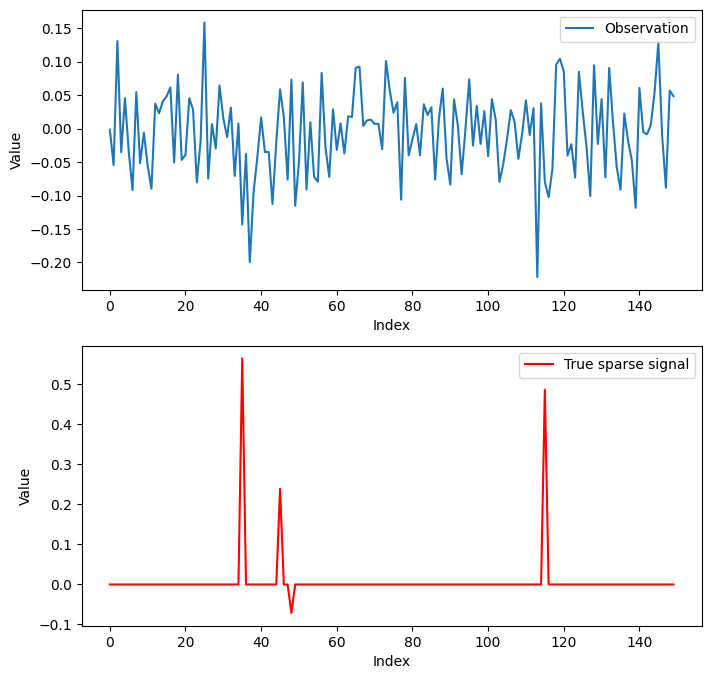

In [44]:
x_exm, s_exm =test_set.dataset.__getitem__(0)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'Observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'True sparse signal', color='r')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend()
plt.show()

In [45]:
class NCS_EXP_LAYER(nn.Module):
    def __init__(self, A, lambd = 0.1):
        super().__init__()

        self.A = A
        self.L = 2*torch.max(torch.real(torch.linalg.eigvals(A.t() @ A)))
        self.lambd = lambd

        # Initialization of the learnable parameter
        self.theta = nn.Parameter(torch.randn(1), requires_grad=True)       
        
    def etaEXP(self):
        return self.theta
    
    def ddxEXP(self, x):
        return torch.sign(x) * self.theta * (1 - torch.exp(- self.theta * torch.abs(x)))
    
    def B(self, z, x):
        return x - 2/self.L*(x @ self.A.t() @ self.A - (self.A.t() @ z.t()).t()) + self.lambd/self.L * (self.ddxEXP(x))
    
    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)
    
    def forward(self, z, x):   

        K = self.etaEXP() * self.lambd / self.L    
        if x is None:
            x = torch.zeros(z.shape[0], self.A.shape[1])

        return self._shrink(self.B(z, x), K)

In [46]:
class NCSEXP_Net(nn.Module):
    def __init__(self, A, lambd = 0.1, K = 5):
        super(NCSEXP_Net, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        # Layers
        self.NCSEXP_layers = nn.ModuleList([NCS_EXP_LAYER(A, lambd) for _ in range(self.K + 1)])

        # Losses when doing inference
        self.losses = []

    def forward(self, z):     

        x = self.NCSEXP_layers[0].forward(z,None)

        for i in range(1, self.K + 1):
            
            x = self.NCSEXP_layers[i].forward(z,x)
                
        return x

In [47]:
def train(model, train_loader, valid_loader, num_epochs=50, verbose = True):

    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )

    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    # Main train loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for _, (Y, S) in enumerate(train_loader):
            S_hat = model.forward(Y)
            loss = F.mse_loss(S_hat, S, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for _, (Y, S) in enumerate(valid_loader):
            S_hat = model.forward(Y)
            loss = F.mse_loss(S_hat, S, reduction="sum")
            optimizer.zero_grad()
            test_loss += F.mse_loss(S_hat, S, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        # Log progress
        if verbose and epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_train, loss_test

In [48]:
model_1 = NCSEXP_Net(A_, 1, 5)

In [49]:
train_loss_1, test_loss_1 = train(model_1, train_set, test_set, num_epochs=50)

Epoch 0, Train loss 0.30245180, Validation loss 0.30749538
Epoch 10, Train loss 0.23822783, Validation loss 0.23843702
Epoch 20, Train loss 0.18607868, Validation loss 0.18984735
Epoch 30, Train loss 0.16446388, Validation loss 0.16960840
Epoch 40, Train loss 0.15661339, Validation loss 0.16123907


In [50]:
class LISTA_LAYER(nn.Module):
    def __init__(self, A):
        super().__init__()

        # Initialization of the learnable parameters
        self.A = A
        self.W1 = nn.Linear(A.shape[0], A.shape[1], bias=False)
        self.W2 = nn.Linear(A.shape[1], A.shape[1], bias=False)

        self.beta = nn.Parameter(torch.ones(1, 1, 1), requires_grad=True)       
        
        self.W1.weight.data = A.t()
        self.W2.weight.data = A.t() @ A
        
    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)
    
    def forward(self, y, x):       
        if x is None:
            x = torch.zeros(y.shape[0], self.A.shape[1])

        return self._shrink(self.W1(y) + self.W2(x), 
                            self.beta)

In [15]:
class LISTA_Net_R(nn.Module):
    def __init__(self, A, K = 5):
        super(LISTA_Net_R, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        #Parameters
        self.W1 = nn.Linear(A.shape[0], A.shape[1], bias=False)
        self.W2 = nn.Linear(A.shape[1], A.shape[1], bias=False)

        self.beta = nn.Parameter(torch.ones(self.K + 1, 1, 1), requires_grad=True)       
        
        self.W1.weight.data = A.t()
        self.W2.weight.data = A.t() @ A

        # Losses when doing inference
        self.losses = []

    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)
    
    def forward(self, y, S = None):     

        x = self._shrink(self.W1(y) , 
                            self.beta[0, : ,:])

        for i in range(1, self.K + 1):

            x = self._shrink(self.W1(y) + self.W2(x), self.beta[i, : ,:])

            if S is not None:
                self.losses.append(F.mse_loss(x.detach(), S.detach(), reduction="sum").data.item())
                
        return x

In [51]:
class LISTA_Net(nn.Module):
    def __init__(self, A, K = 5):
        super(LISTA_Net, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        # Layers
        self.LISTA_layers = nn.ModuleList([LISTA_LAYER(A) for _ in range(self.K + 1)])

        # Losses when doing inference
        self.losses = []

    def forward(self, y, S = None):     

        x = self.LISTA_layers[0].forward(y,None)

        for i in range(1, self.K + 1):

            x = self.LISTA_layers[i].forward(y,x)

            if S is not None:
                self.losses.append(F.mse_loss(x.detach(), S.detach(), reduction="sum").data.item())
                
        return x

In [52]:
model_2 = LISTA_Net_R(A_, 5)

In [53]:
train_loss_2, test_loss_2 = train(model_2, train_set, test_set, num_epochs=50)

Epoch 0, Train loss 0.98597116, Validation loss 0.91015915
Epoch 10, Train loss 0.78561817, Validation loss 0.92828079
Epoch 20, Train loss 0.22096534, Validation loss 0.29748795
Epoch 30, Train loss 0.15470849, Validation loss 0.18152390
Epoch 40, Train loss 0.14213438, Validation loss 0.17085909


In [54]:
model_3 = LISTA_Net(A_, 5)

In [55]:
train_loss_3, test_loss_3 = train(model_3, train_set, test_set, num_epochs=50)

Epoch 0, Train loss 0.78415791, Validation loss 1.02239655
Epoch 10, Train loss 0.69236042, Validation loss 1.02586044
Epoch 20, Train loss 0.16223111, Validation loss 0.31267126
Epoch 30, Train loss 0.13756922, Validation loss 0.17174208
Epoch 40, Train loss 0.12593901, Validation loss 0.16323399


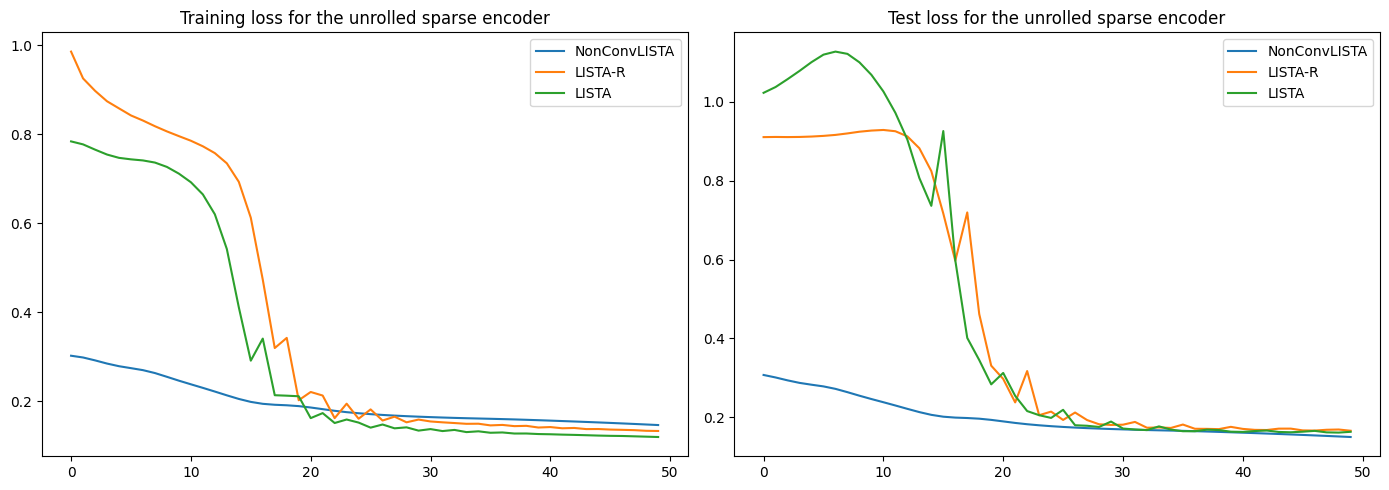

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Training Loss
axs[0].plot(train_loss_1, label = 'NonConvLISTA')
axs[0].plot(train_loss_2, label = 'LISTA-R')
axs[0].plot(train_loss_3, label = 'LISTA')
axs[0].legend()
axs[0].set_title('Training loss for the unrolled sparse encoder')

# Plot for Test Loss
axs[1].plot(test_loss_1, label='NonConvLISTA')
axs[1].plot(test_loss_2, label='LISTA-R')
axs[1].plot(test_loss_3, label = 'LISTA')
axs[1].legend()
axs[1].set_title('Test loss for the unrolled sparse encoder')

plt.tight_layout()
plt.show()

In [23]:
num_epochs = 50
sims = 100

NCLISTA_train_loss = np.zeros((num_epochs, sims))
LISTA_R_train_loss = np.zeros((num_epochs, sims))
LISTA_train_loss = np.zeros((num_epochs, sims))

NCLISTA_test_loss = np.zeros((num_epochs, sims))
LISTA_R_test_loss = np.zeros((num_epochs, sims))
LISTA_test_loss = np.zeros((num_epochs, sims))

for T in tqdm(range(100)):
    # Dimensions for the signal, its sparsity and its observation

    m_ = 150
    n_ = 150
    s_ = 4

    # Measurement matrix
    A_ = torch.randn(m_,n_)
    A_ /= torch.norm(A_, dim=0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(A = A_,
                                n = n_,
                                m = m_,
                                s = s_,
                                size = 800).set_loader()

    test_set = SyntheticSignals(A = A_,
                                n = n_,
                                m = m_,
                                s = s_,
                                size = 200).set_loader()
    
    model_1 = NCSEXP_Net(A_, 1, 5)
    train_loss_1, test_loss_1 = train(model_1, train_set, test_set, verbose=False, num_epochs=50)

    model_2 = LISTA_Net_R(A_, 5)
    train_loss_2, test_loss_2 = train(model_2, train_set, test_set, verbose=False, num_epochs=50)

    model_3 = LISTA_Net(A_, 5)
    train_loss_3, test_loss_3 = train(model_3, train_set, test_set, verbose=False, num_epochs=50)

    NCLISTA_train_loss[:,T] = train_loss_1
    LISTA_R_train_loss[:,T] = train_loss_2
    LISTA_train_loss[:,T] = train_loss_3

    NCLISTA_test_loss[:,T] = test_loss_1
    LISTA_R_test_loss[:,T] = test_loss_2
    LISTA_test_loss[:,T] = test_loss_3

100%|██████████| 100/100 [09:43<00:00,  5.83s/it]


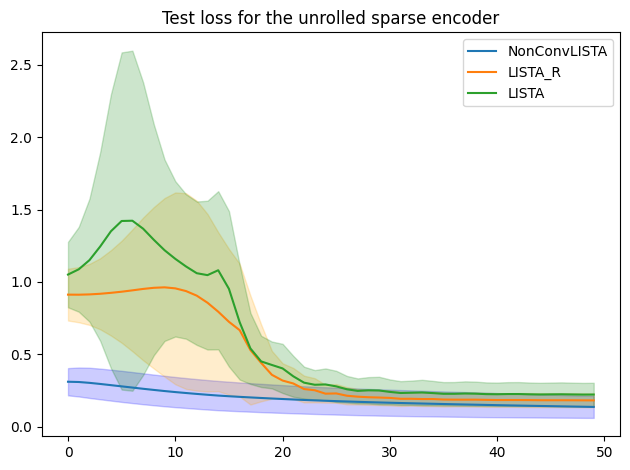

In [29]:
# Plot for Test Loss
plt.plot(np.mean(NCLISTA_test_loss, axis = 1), label='NonConvLISTA')
plt.fill_between(range(num_epochs), 
                    np.mean(NCLISTA_test_loss, axis = 1) - np.std(NCLISTA_test_loss, axis = 1), 
                    np.mean(NCLISTA_test_loss, axis = 1) + np.std(NCLISTA_test_loss, axis = 1), 
                    color='blue', 
                    alpha=0.2)

plt.plot(np.mean(LISTA_R_test_loss, axis = 1), label='LISTA_R')
plt.fill_between(range(num_epochs), 
                    np.mean(LISTA_R_test_loss, axis = 1) - np.std(LISTA_R_test_loss, axis = 1), 
                    np.mean(LISTA_R_test_loss, axis = 1) + np.std(LISTA_R_test_loss, axis = 1), 
                    color='orange', 
                    alpha=0.2)
plt.plot(np.mean(LISTA_test_loss, axis = 1), label='LISTA')
plt.fill_between(range(num_epochs), 
                    np.mean(LISTA_test_loss, axis = 1) - np.std(LISTA_test_loss, axis = 1), 
                    np.mean(LISTA_test_loss, axis = 1) + np.std(LISTA_test_loss, axis = 1), 
                    color='green', 
                    alpha=0.2)
plt.legend()
plt.title('Test loss for the unrolled sparse encoder')

plt.tight_layout()
plt.show()

________

# Let's build a general model for the other nonconvex relaxations

In [32]:
class NCS_LAYER(nn.Module):
    def __init__(self, A, mode, lambd = 0.1):
        super().__init__()

        self.A = A
        self.L = 2*torch.max(torch.real(torch.linalg.eigvals(A.t() @ A)))
        self.lambd = lambd
        self.mode = mode

        # Initialization of the learnable parameter
        self.theta = nn.Parameter(torch.rand(1), requires_grad=True)  

        # Mode setting for the layer
        if mode == 'EXP':
            self.ddx = self.ddxEXP
            self.eta = self.etaEXP

        if mode == 'PPOS':     
            self.eps = 1
            self.ddx = self.ddxPOS
            self.eta = self.etaPOS

        if mode == 'PNEG':
            self.p = 0.5
            self.ddx = self.ddxNEG
            self.eta = self.etaNEG

        if mode == 'SCAD':
            self.a = 2
            self.ddx = self.ddxSCAD
            self.eta = self.etaSCAD

        if mode == 'LOG':
            self.ddx = self.ddxLOG
            self.eta = self.etaLOG

    #_________________________________________________________________
    #______________ METHODS FOR ENABLING DIFFERENT LAYERS_____________
    #_________________________________________________________________
    
    # Derivatives of the nonconvex components
    def ddxEXP(self, x):
        return torch.sign(x) * self.theta * (1 - torch.exp(-self.theta * torch.abs(x)))

    def ddxPOS(self, x):
        return (1 / self.theta) * torch.sign(x) * (self.eps**(1 / self.theta - 1) - (torch.abs(x) + self.eps)**(1 / self.theta - 1))

    def ddxNEG(self, x):
        return -torch.sign(x) * self.p * self.theta * (1 - (1 + self.theta * torch.abs(x))**(self.p - 1))

    def ddxSCAD(self, x):
        abs_x = torch.abs(x)
        
        mask1 = (abs_x <= 1)
        mask2 = (1 / self.theta < abs_x) & (abs_x <= self.a / self.theta)
        mask3 = (abs_x > self.a / self.theta)
        
        # Compute the value for each condition
        val1 = torch.zeros_like(x)
        val2 = torch.sign(x) * (2 * self.theta * (self.theta * abs_x - 1)) / (self.a**2 - 1)
        val3 = torch.sign(x) * (2 * self.theta / (self.a + 1))
        
        # Apply the masks to compute the final result
        result = torch.where(mask1, val1, torch.where(mask2, val2, val3))
        
        return result


    def ddxLOG(self, x):
        return torch.sign(x) * (self.theta**2 * torch.abs(x)) / (torch.log(1 + self.theta) * (1 + self.theta * torch.abs(x)))

    # Parametrization for the surrogates
    def etaEXP(self):
        return self.theta

    def etaPOS(self):
        return 1 / self.theta * self.eps ** (1 / self.theta - 1)

    def etaNEG(self):
        return - self.p * self.theta

    def etaSCAD(self):
        return 2 * self.theta / (self.a + 1)

    def etaLOG(self):
        return self.theta**2 / torch.log(self.theta**2 + 1)
    
    #___________________________________________________________________
    #___________________________________________________________________

    def B(self, z, x):
        return x - 2/self.L*(x @ self.A.t() @ self.A - (self.A.t() @ z.t()).t()) + self.lambd/self.L * (self.ddx(x))

    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)

    def forward(self, z, x):   

        K = self.eta() * self.lambd / self.L    
        if x is None:
            x = torch.zeros(z.shape[0], self.A.shape[1])

        return self._shrink(self.B(z, x), K)

In [33]:
class NCS_Net(nn.Module):
    def __init__(self, A, mode, lambd = 0.1, K = 5):
        super(NCS_Net, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        # Layers
        self.NCS_layers = nn.ModuleList([NCS_LAYER(A, mode, lambd) for _ in range(self.K + 1)])

        # Losses when doing inference
        self.losses = []

    def forward(self, z):     

        x = self.NCS_layers[0].forward(z,None)

        for i in range(1, self.K + 1):
            
            x = self.NCS_layers[i].forward(z,x)
                
        return x

In [34]:
num_epochs = 50
sims = 100

NCLISTA_exp_train_loss = np.zeros((num_epochs, sims))
NCLISTA_pneg_train_loss = np.zeros((num_epochs, sims))
NCLISTA_scad_train_loss = np.zeros((num_epochs, sims))
LISTA_R_train_loss = np.zeros((num_epochs, sims))
LISTA_train_loss = np.zeros((num_epochs, sims))

NCLISTA_exp_test_loss = np.zeros((num_epochs, sims))
NCLISTA_pneg_test_loss = np.zeros((num_epochs, sims))
NCLISTA_scad_test_loss = np.zeros((num_epochs, sims))
LISTA_R_test_loss = np.zeros((num_epochs, sims))
LISTA_test_loss = np.zeros((num_epochs, sims))

for T in tqdm(range(100)):
    # Dimensions for the signal, its sparsity and its observation

    m_ = 150
    n_ = 150
    s_ = 4

    # Measurement matrix
    A_ = torch.randn(m_,n_)
    A_ /= torch.norm(A_, dim=0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(A = A_,
                                n = n_,
                                m = m_,
                                s = s_,
                                size = 800).set_loader()

    test_set = SyntheticSignals(A = A_,
                                n = n_,
                                m = m_,
                                s = s_,
                                size = 200).set_loader()
    
    model_1 = NCS_Net(A_, 'EXP', 1, 5)
    train_loss_1, test_loss_1 = train(model_1, train_set, test_set, verbose=False, num_epochs=50)

    model_2 = NCS_Net(A_, 'PNEG', 1, 5)
    train_loss_2, test_loss_2 = train(model_2, train_set, test_set, verbose=False, num_epochs=50)

    model_3 = NCS_Net(A_, 'SCAD', 1, 5)
    train_loss_3, test_loss_3 = train(model_3, train_set, test_set, verbose=False, num_epochs=50)

    model_4 = LISTA_Net_R(A_, 5)
    train_loss_4, test_loss_4 = train(model_4, train_set, test_set, verbose=False, num_epochs=50)

    model_5 = LISTA_Net(A_, 5)
    train_loss_5, test_loss_5 = train(model_5, train_set, test_set, verbose=False, num_epochs=50)

    NCLISTA_exp_train_loss[:,T] = train_loss_1
    NCLISTA_pneg_train_loss[:,T] = train_loss_2
    NCLISTA_scad_train_loss[:,T] = train_loss_3
    LISTA_R_train_loss[:,T] = train_loss_4
    LISTA_train_loss[:,T] = train_loss_5

    NCLISTA_exp_test_loss[:,T] = test_loss_1
    NCLISTA_pneg_test_loss[:,T] = test_loss_2
    NCLISTA_scad_test_loss[:,T] = test_loss_3
    LISTA_R_test_loss[:,T] = test_loss_4
    LISTA_test_loss[:,T] = test_loss_5

100%|██████████| 100/100 [19:07<00:00, 11.47s/it]


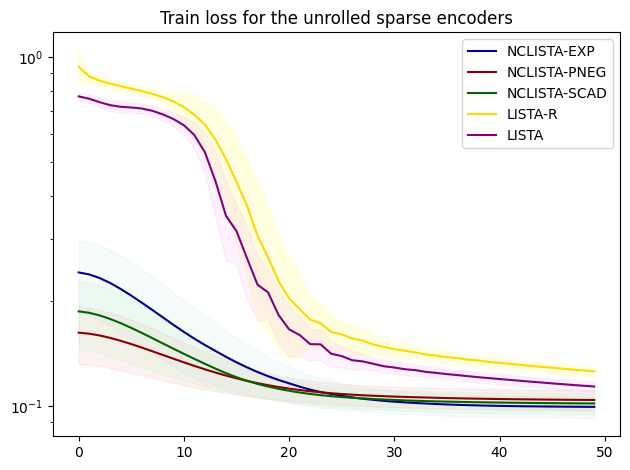

In [58]:
# Plot for Test Loss
plt.plot(np.mean(NCLISTA_exp_train_loss, axis = 1), label='NCLISTA-EXP', color='darkblue')
plt.fill_between(range(num_epochs), 
                    np.mean(NCLISTA_exp_train_loss, axis = 1) - np.std(NCLISTA_exp_train_loss, axis = 1), 
                    np.mean(NCLISTA_exp_train_loss, axis = 1) + np.std(NCLISTA_exp_train_loss, axis = 1), 
                    color='lightblue', 
                    alpha=0.1)

plt.plot(np.mean(NCLISTA_pneg_train_loss, axis = 1), label='NCLISTA-PNEG', color='darkred')
plt.fill_between(range(num_epochs), 
                    np.mean(NCLISTA_pneg_train_loss, axis = 1) - np.std(NCLISTA_pneg_train_loss, axis = 1), 
                    np.mean(NCLISTA_pneg_train_loss, axis = 1) + np.std(NCLISTA_pneg_train_loss, axis = 1), 
                    color='lightcoral', 
                    alpha=0.1)

plt.plot(np.mean(NCLISTA_scad_train_loss, axis = 1), label='NCLISTA-SCAD', color='darkgreen')
plt.fill_between(range(num_epochs), 
                    np.mean(NCLISTA_scad_train_loss, axis = 1) - np.std(NCLISTA_scad_train_loss, axis = 1), 
                    np.mean(NCLISTA_scad_train_loss, axis = 1) + np.std(NCLISTA_scad_train_loss, axis = 1), 
                    color='lightgreen', 
                    alpha=0.1)

plt.plot(np.mean(LISTA_R_train_loss, axis = 1), label='LISTA-R', color='gold')
plt.fill_between(range(num_epochs), 
                    np.mean(LISTA_R_train_loss, axis = 1) - np.std(LISTA_R_train_loss, axis = 1), 
                    np.mean(LISTA_R_train_loss, axis = 1) + np.std(LISTA_R_train_loss, axis = 1), 
                    color='lightyellow', 
                    alpha=1)

plt.plot(np.mean(LISTA_train_loss, axis = 1), label='LISTA', color='purple')
plt.fill_between(range(num_epochs), 
                    np.mean(LISTA_train_loss, axis = 1) - np.std(LISTA_train_loss, axis = 1), 
                    np.mean(LISTA_train_loss, axis = 1) + np.std(LISTA_train_loss, axis = 1), 
                    color='violet', 
                    alpha=0.1)
plt.legend()
plt.title('Train loss for the unrolled sparse encoders')
plt.yscale('log')
plt.tight_layout()
plt.show()

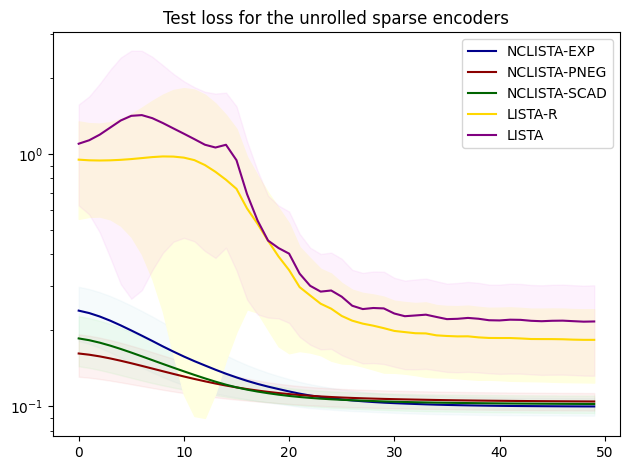

In [40]:
# Plot for Test Loss
plt.plot(np.mean(NCLISTA_exp_test_loss, axis = 1), label='NCLISTA-EXP', color='darkblue')
plt.fill_between(range(num_epochs), 
                    np.mean(NCLISTA_exp_test_loss, axis = 1) - np.std(NCLISTA_exp_test_loss, axis = 1), 
                    np.mean(NCLISTA_exp_test_loss, axis = 1) + np.std(NCLISTA_exp_test_loss, axis = 1), 
                    color='lightblue', 
                    alpha=0.1)

plt.plot(np.mean(NCLISTA_pneg_test_loss, axis = 1), label='NCLISTA-PNEG', color='darkred')
plt.fill_between(range(num_epochs), 
                    np.mean(NCLISTA_pneg_test_loss, axis = 1) - np.std(NCLISTA_pneg_test_loss, axis = 1), 
                    np.mean(NCLISTA_pneg_test_loss, axis = 1) + np.std(NCLISTA_pneg_test_loss, axis = 1), 
                    color='lightcoral', 
                    alpha=0.1)

plt.plot(np.mean(NCLISTA_scad_test_loss, axis = 1), label='NCLISTA-SCAD', color='darkgreen')
plt.fill_between(range(num_epochs), 
                    np.mean(NCLISTA_scad_test_loss, axis = 1) - np.std(NCLISTA_scad_test_loss, axis = 1), 
                    np.mean(NCLISTA_scad_test_loss, axis = 1) + np.std(NCLISTA_scad_test_loss, axis = 1), 
                    color='lightgreen', 
                    alpha=0.1)

plt.plot(np.mean(LISTA_R_test_loss, axis = 1), label='LISTA-R', color='gold')
plt.fill_between(range(num_epochs), 
                    np.mean(LISTA_R_test_loss, axis = 1) - np.std(LISTA_R_test_loss, axis = 1), 
                    np.mean(LISTA_R_test_loss, axis = 1) + np.std(LISTA_R_test_loss, axis = 1), 
                    color='lightyellow', 
                    alpha=1)

plt.plot(np.mean(LISTA_test_loss, axis = 1), label='LISTA', color='purple')
plt.fill_between(range(num_epochs), 
                    np.mean(LISTA_test_loss, axis = 1) - np.std(LISTA_test_loss, axis = 1), 
                    np.mean(LISTA_test_loss, axis = 1) + np.std(LISTA_test_loss, axis = 1), 
                    color='violet', 
                    alpha=0.1)
plt.legend()
plt.title('Test loss for the unrolled sparse encoders')
plt.yscale('log')
plt.tight_layout()
plt.show()

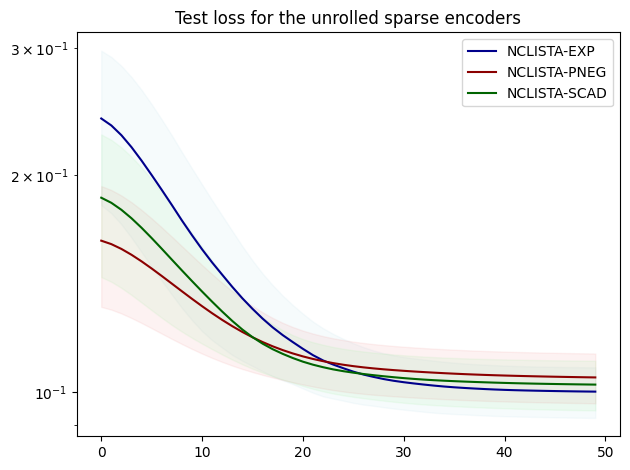

In [39]:
# Plot for Test Loss
plt.plot(np.mean(NCLISTA_exp_test_loss, axis = 1), label='NCLISTA-EXP', color='darkblue')
plt.fill_between(range(num_epochs), 
                    np.mean(NCLISTA_exp_test_loss, axis = 1) - np.std(NCLISTA_exp_test_loss, axis = 1), 
                    np.mean(NCLISTA_exp_test_loss, axis = 1) + np.std(NCLISTA_exp_test_loss, axis = 1), 
                    color='lightblue', 
                    alpha=0.1)

plt.plot(np.mean(NCLISTA_pneg_test_loss, axis = 1), label='NCLISTA-PNEG', color='darkred')
plt.fill_between(range(num_epochs), 
                    np.mean(NCLISTA_pneg_test_loss, axis = 1) - np.std(NCLISTA_pneg_test_loss, axis = 1), 
                    np.mean(NCLISTA_pneg_test_loss, axis = 1) + np.std(NCLISTA_pneg_test_loss, axis = 1), 
                    color='lightcoral', 
                    alpha=0.1)

plt.plot(np.mean(NCLISTA_scad_test_loss, axis = 1), label='NCLISTA-SCAD', color='darkgreen')
plt.fill_between(range(num_epochs), 
                    np.mean(NCLISTA_scad_test_loss, axis = 1) - np.std(NCLISTA_scad_test_loss, axis = 1), 
                    np.mean(NCLISTA_scad_test_loss, axis = 1) + np.std(NCLISTA_scad_test_loss, axis = 1), 
                    color='lightgreen', 
                    alpha=0.1)

plt.legend()
plt.title('Test loss for the unrolled sparse encoders')
plt.yscale('log')
plt.tight_layout()
plt.show()